In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Source

In [ ]:
from pathlib import Path
data_path = Path('/content/drive/MyDrive/FacialAge/Data')
model_path = Path('/content/drive/MyDrive/FacialAge/Model_V2')

# Preprocessing

## Parameter

In [ ]:
width = height = 224
img_size = (width, height)
img_shape = img_size + (3, )
batch_size = 32 
initial_epochs = 50
fine_tune_epochs = 50
seed = 10
learning_rate = 1e-4
results = {}

## Load data
70% train, 15% test, 15% val

### Train Dataset

In [ ]:
from tensorflow.data.experimental import cardinality
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
                                      data_path,
                                      labels="inferred",
                                      label_mode="int",
                                      class_names=None,
                                      seed=seed,
                                      image_size=img_size,
                                      smart_resize=True,
                                      batch_size=batch_size)
temp_ds = train_ds
train_batches = cardinality(train_ds)

Found 9778 files belonging to 99 classes.


In [ ]:
class_names = train_ds.class_names
num_class = len(class_names)
print(num_class,' : ', class_names)

99  :  ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']


### Test Dataset

In [ ]:
test_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

### Val Dataset

In [ ]:
val_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

## Data Visualization

### Overview

In [ ]:
import os
import numpy as np
labels = []
files = []
for a in os.walk(data_path):
    labels = a[1]
    break
for a in os.walk(data_path):
    files.append(len(a[2]))
files.remove(0)
a = []
for i in range(99):
    a. append([int(labels[i]),files[i]]) 
num_class = len(labels)
num_files = sum(files)
a.sort()
a = np.array(a)

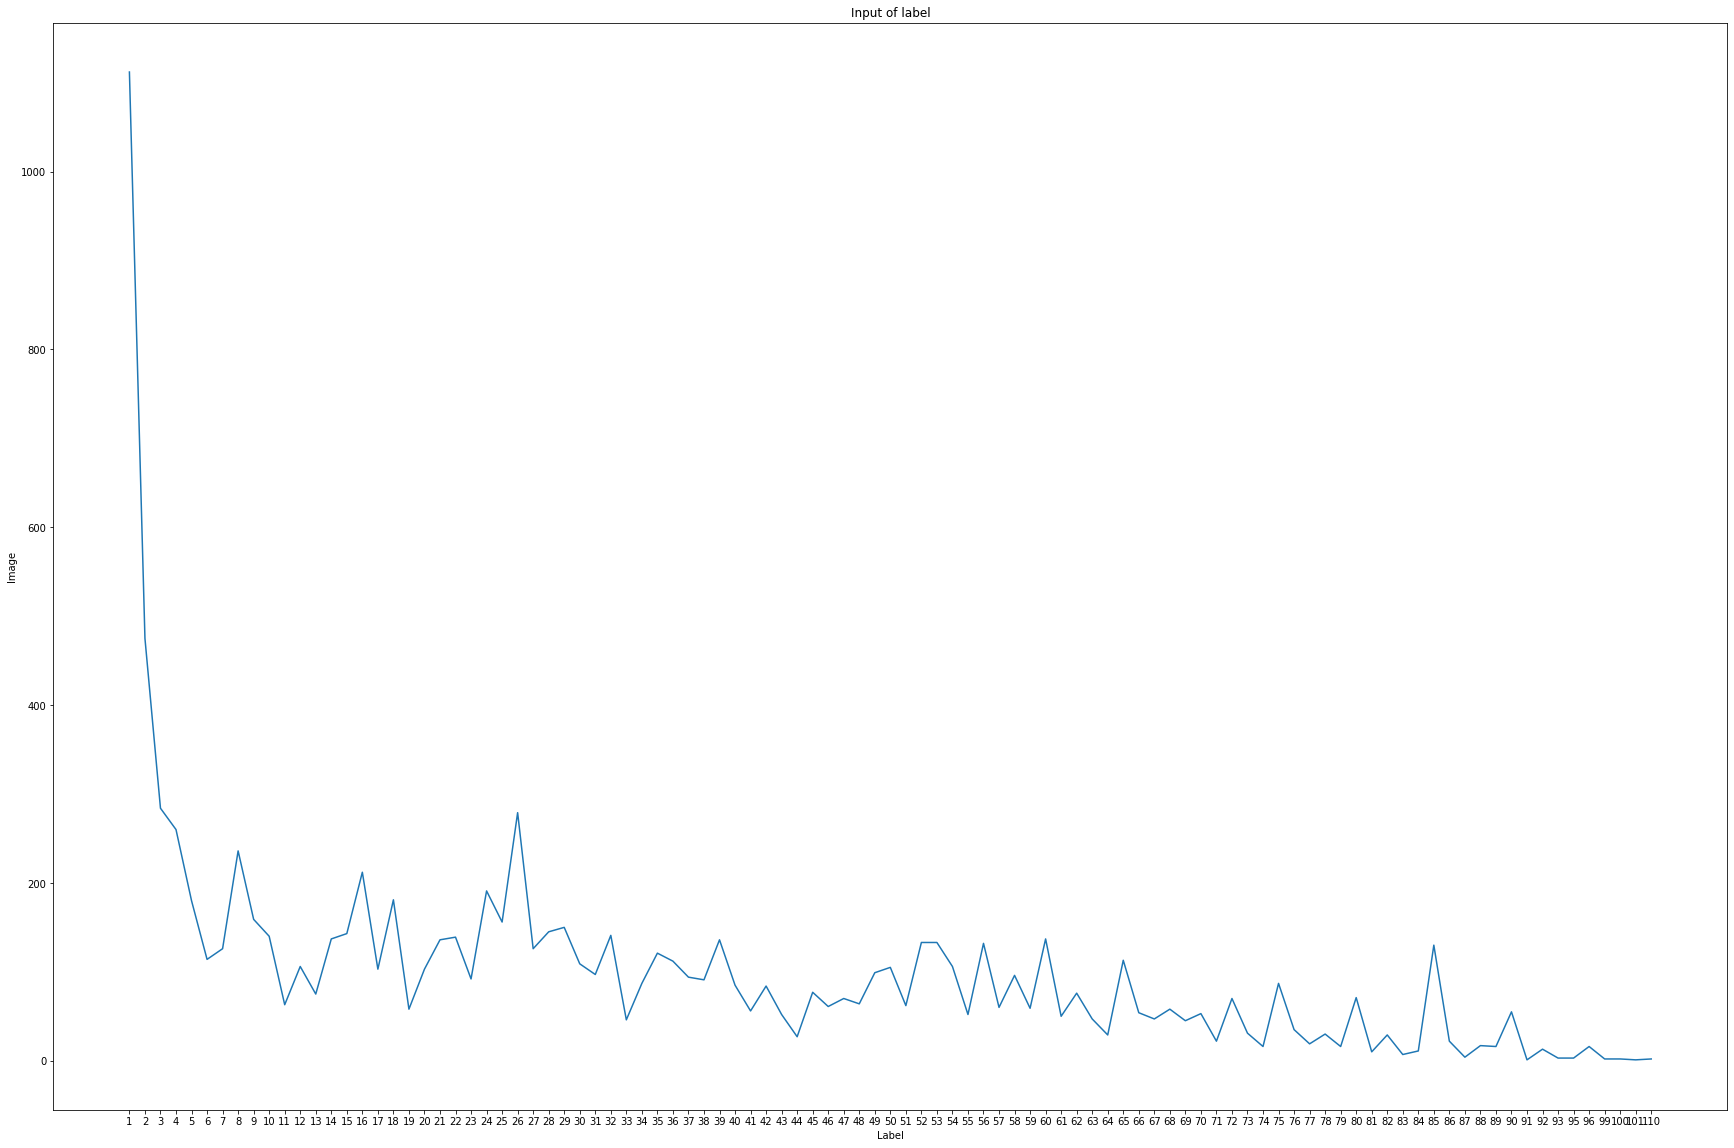

In [ ]:
import matplotlib.pyplot as plt
X = a[:,0]
Y = a[:,1]
X_axis = np.arange(len(X))
plt.figure(figsize=(30,20))  
plt.plot(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Image")
plt.title("Input of label")
plt.show()

### Example

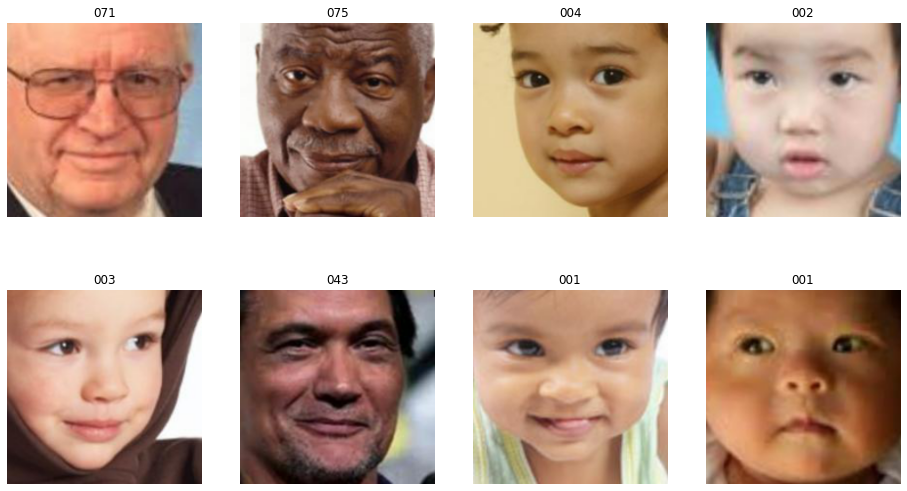

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
images, labels = next(iter(temp_ds))
for i in range(8):
  ax = plt.subplot(2, 4, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(temp_ds.class_names[labels[i]])
  plt.axis("off")

## Data augment

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape = img_shape),
    RandomRotation(0.1),
    RandomZoom(-0.1,0.1),
  ]
)

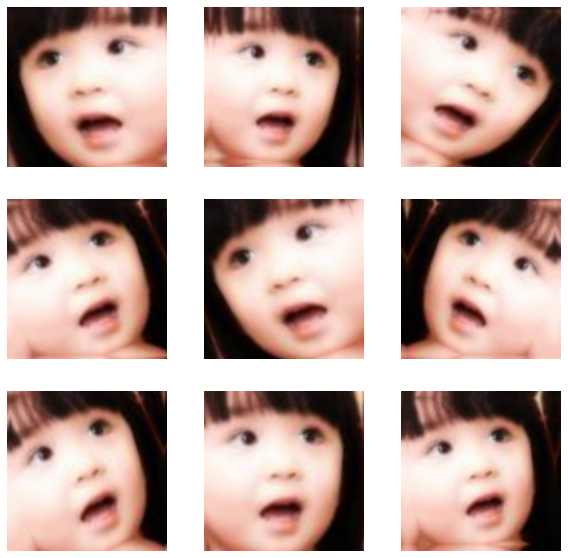

In [ ]:
import tensorflow as tf
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Data Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Call Back 

In [ ]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=1, # if val_loss plateaus for 1 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

#Model

## MobileNet V1

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

# download model MobileNet V1
base_model_V1 = MobileNet(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V1.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V1(x, training=False) 
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V1 = Model(inputs, outputs)
model_V1.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

In [ ]:
model_V1_history = model_V1.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 1139s 5s/step - loss: 20.8637 - mean_absolute_error: 20.8637 - val_loss: 18.3787 - val_mean_absolute_error: 18.3787
Epoch 2/50
216/216 [==============================] - 9s 43ms/step - loss: 16.4086 - mean_absolute_error: 16.4086 - val_loss: 15.3380 - val_mean_absolute_error: 15.3380
Epoch 3/50
216/216 [==============================] - 9s 42ms/step - loss: 14.4263 - mean_absolute_error: 14.4263 - val_loss: 14.0090 - val_mean_absolute_error: 14.0090
Epoch 4/50
216/216 [==============================] - 9s 43ms/step - loss: 13.3066 - mean_absolute_error: 13.3066 - val_loss: 13.0397 - val_mean_absolute_error: 13.0397
Epoch 5/50
216/216 [==============================] - 9s 42ms/step - loss: 12.4924 - mean_absolute_error: 12.4924 - val_loss: 12.3505 - val_mean_absolute_error: 12.3505
Epoch 6/50
216/216 [==============================] - 9s 42ms/step - loss: 11.8515 - mean_absolute_error: 11.8515 - val_loss: 11.7660 - val_mean_absolute_

### Tranfer Learning

In [ ]:
base_model_V1.trainable = True

In [ ]:
len(base_model_V1.layers)

86

In [ ]:
ft_at = 10
for layer in base_model_V1.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V1.layers[ft_at:]:
    layer.trainable = True
model_V1.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V1_fn = model_V1.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V1_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 44/100
216/216 [==============================] - 35s 145ms/step - loss: 10.0210 - mean_absolute_error: 10.0210 - val_loss: 6.9853 - val_mean_absolute_error: 6.9853
Epoch 45/100
216/216 [==============================] - 31s 141ms/step - loss: 7.1743 - mean_absolute_error: 7.1743 - val_loss: 6.2066 - val_mean_absolute_error: 6.2066
Epoch 46/100
216/216 [==============================] - 31s 142ms/step - loss: 6.2335 - mean_absolute_error: 6.2335 - val_loss: 5.5608 - val_mean_absolute_error: 5.5608
Epoch 47/100
216/216 [==============================] - 31s 142ms/step - loss: 5.6858 - mean_absolute_error: 5.6858 - val_loss: 5.7685 - val_mean_absolute_error: 5.7685

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 48/100
216/216 [==============================] - 31s 142ms/step - loss: 4.6510 - mean_absolute_error: 4.6510 - val_loss: 5.1063 - val_mean_absolute_error: 5.1063
Epoch 49/100
216/216 [==============================] - 31s 142ms/step -

In [ ]:
model_V1_train_loss = model_V1_fn.history["loss"]
model_V1_val_loss = model_V1_fn.history["val_loss"]
model_V1_train_acc = model_V1_fn.history["mean_absolute_error"]
model_V1_val_acc = model_V1_fn.history["val_mean_absolute_error"]

results["model_V1"] = {'train-loss': model_V1_train_loss,
                             'val-loss': model_V1_val_loss,
                             'train-mae': model_V1_train_acc,
                             'val-mae': model_V1_val_acc}

## MobileNet V2

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# download model MobileNet V2
base_model_V2 = MobileNetV2(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V2(x, training=False) 
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V2 = Model(inputs, outputs)
model_V2.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3279

In [ ]:
model_V2_history = model_V2.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 14s 52ms/step - loss: 19.4928 - mean_absolute_error: 19.4928 - val_loss: 16.8953 - val_mean_absolute_error: 16.8953
Epoch 2/50
216/216 [==============================] - 10s 48ms/step - loss: 15.5132 - mean_absolute_error: 15.5132 - val_loss: 14.9300 - val_mean_absolute_error: 14.9300
Epoch 3/50
216/216 [==============================] - 10s 48ms/step - loss: 13.9509 - mean_absolute_error: 13.9509 - val_loss: 13.7680 - val_mean_absolute_error: 13.7680
Epoch 4/50
216/216 [==============================] - 10s 48ms/step - loss: 12.9592 - mean_absolute_error: 12.9592 - val_loss: 12.9687 - val_mean_absolute_error: 12.9687
Epoch 5/50
216/216 [==============================] - 10s 48ms/step - loss: 12.2308 - mean_absolute_error: 12.2308 - val_loss: 12.3596 - val_mean_absolute_error: 12.3596
Epoch 6/50
216/216 [==============================] - 10s 48ms/step - loss: 11.6535 - mean_absolute_error: 11.6535 - val_loss: 11.8647 - val_mean_abso

### Tranfer Learning

In [ ]:
base_model_V2.trainable = True

In [ ]:
len(base_model_V2.layers)

154

In [ ]:
ft_at = 30
for layer in base_model_V2.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V2.layers[ft_at:]:
    layer.trainable = True
model_V2.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V2_fn = model_V2.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V2_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 50/100
216/216 [==============================] - 26s 105ms/step - loss: 9.2878 - mean_absolute_error: 9.2878 - val_loss: 7.0882 - val_mean_absolute_error: 7.0882
Epoch 51/100
216/216 [==============================] - 22s 100ms/step - loss: 6.4281 - mean_absolute_error: 6.4281 - val_loss: 6.2927 - val_mean_absolute_error: 6.2927
Epoch 52/100
216/216 [==============================] - 22s 100ms/step - loss: 5.8429 - mean_absolute_error: 5.8429 - val_loss: 5.7384 - val_mean_absolute_error: 5.7384
Epoch 53/100
216/216 [==============================] - 22s 101ms/step - loss: 5.3922 - mean_absolute_error: 5.3922 - val_loss: 5.1232 - val_mean_absolute_error: 5.1232
Epoch 54/100
216/216 [==============================] - 22s 100ms/step - loss: 4.9992 - mean_absolute_error: 4.9992 - val_loss: 5.6128 - val_mean_absolute_error: 5.6128

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 55/100
216/216 [==============================] - 22s 102ms/step - l

In [ ]:
model_V2_train_loss = model_V2_fn.history["loss"]
model_V2_val_loss = model_V2_fn.history["val_loss"]
model_V2_train_acc = model_V2_fn.history["mean_absolute_error"]
model_V2_val_acc = model_V2_fn.history["val_mean_absolute_error"]

results["model_V2"] = {'train-loss': model_V2_train_loss,
                             'val-loss': model_V2_val_loss,
                             'train-mae': model_V2_train_acc,
                             'val-mae': model_V2_val_acc}

## MobileNet V3L

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3L
base_model_V3L = MobileNetV3Large(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3L.trainable = False

17612800/17605208 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V3L(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V3L = Model(inputs, outputs)
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3L.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 4,554,625
Trainable params: 328,193
Non-trainable params: 4,226,432
___________________________________________

In [ ]:
model_V3L_history = model_V3L.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 15s 52ms/step - loss: 18.8350 - mean_absolute_error: 18.8350 - val_loss: 16.0653 - val_mean_absolute_error: 16.0653
Epoch 2/50
216/216 [==============================] - 10s 46ms/step - loss: 14.9092 - mean_absolute_error: 14.9092 - val_loss: 14.1794 - val_mean_absolute_error: 14.1794
Epoch 3/50
216/216 [==============================] - 10s 46ms/step - loss: 13.4981 - mean_absolute_error: 13.4981 - val_loss: 13.1599 - val_mean_absolute_error: 13.1599
Epoch 4/50
216/216 [==============================] - 10s 46ms/step - loss: 12.5812 - mean_absolute_error: 12.5812 - val_loss: 12.3402 - val_mean_absolute_error: 12.3402
Epoch 5/50
216/216 [==============================] - 10s 46ms/step - loss: 11.8731 - mean_absolute_error: 11.8731 - val_loss: 11.7371 - val_mean_absolute_error: 11.7371
Epoch 6/50
216/216 [==============================] - 10s 46ms/step - loss: 11.2662 - mean_absolute_error: 11.2662 - val_loss: 11.3025 - val_mean_abso

### Tranfer Learning

In [ ]:
base_model_V3L.trainable = True

In [ ]:
len(base_model_V3L.layers)

276

In [ ]:
ft_at = 30
for layer in base_model_V3L.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3L.layers[ft_at:]:
    layer.trainable = True
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3L_fn = model_V3L.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3L_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 50/100
216/216 [==============================] - 31s 121ms/step - loss: 6.9262 - mean_absolute_error: 6.9262 - val_loss: 5.8929 - val_mean_absolute_error: 5.8929
Epoch 51/100
216/216 [==============================] - 25s 114ms/step - loss: 5.5827 - mean_absolute_error: 5.5827 - val_loss: 5.3500 - val_mean_absolute_error: 5.3500
Epoch 52/100
216/216 [==============================] - 25s 115ms/step - loss: 4.9719 - mean_absolute_error: 4.9719 - val_loss: 5.1602 - val_mean_absolute_error: 5.1602
Epoch 53/100
216/216 [==============================] - 24s 113ms/step - loss: 4.3201 - mean_absolute_error: 4.3201 - val_loss: 5.1187 - val_mean_absolute_error: 5.1187
Epoch 54/100
216/216 [==============================] - 24s 112ms/step - loss: 3.9641 - mean_absolute_error: 3.9641 - val_loss: 5.3721 - val_mean_absolute_error: 5.3721

Epoch 00054: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 55/100
216/216 [==============================] - 25s 115ms/step - l

In [ ]:
model_V3L_train_loss = model_V3L_fn.history["loss"]
model_V3L_val_loss = model_V3L_fn.history["val_loss"]
model_V3L_train_acc = model_V3L_fn.history["mean_absolute_error"]
model_V3L_val_acc = model_V3L_fn.history["val_mean_absolute_error"]

results["model_V3L"] = {'train-loss': model_V3L_train_loss,
                             'val-loss': model_V3L_val_loss,
                             'train-mae': model_V3L_train_acc,
                             'val-mae': model_V3L_val_acc}

## MobileNet V3S

### Base Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3S
base_model_V3S = MobileNetV3Small(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3S.trainable = False

6701056/6698480 [==============================] - 0s 0us/step


### Build Model

In [ ]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V3S(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_V3S = Model(inputs, outputs)
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3S.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 1,792,625
Trainable params: 262,657
Non-trainable params: 1,529,968
___________________________________________

In [ ]:
model_V3S_history = model_V3S.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 9s 28ms/step - loss: 20.0748 - mean_absolute_error: 20.0748 - val_loss: 17.2167 - val_mean_absolute_error: 17.2167
Epoch 2/50
216/216 [==============================] - 5s 24ms/step - loss: 15.7255 - mean_absolute_error: 15.7255 - val_loss: 14.8388 - val_mean_absolute_error: 14.8388
Epoch 3/50
216/216 [==============================] - 5s 23ms/step - loss: 13.9891 - mean_absolute_error: 13.9891 - val_loss: 13.6854 - val_mean_absolute_error: 13.6854
Epoch 4/50
216/216 [==============================] - 5s 24ms/step - loss: 12.9920 - mean_absolute_error: 12.9920 - val_loss: 12.9092 - val_mean_absolute_error: 12.9092
Epoch 5/50
216/216 [==============================] - 5s 24ms/step - loss: 12.2725 - mean_absolute_error: 12.2725 - val_loss: 12.2911 - val_mean_absolute_error: 12.2911
Epoch 6/50
216/216 [==============================] - 5s 24ms/step - loss: 11.6530 - mean_absolute_error: 11.6530 - val_loss: 11.8427 - val_mean_absolute_e

### Tranfer Learning

In [ ]:
base_model_V3S.trainable = True

In [ ]:
len(base_model_V3S.layers)

243

In [ ]:
ft_at = 30
for layer in base_model_V3S.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3S.layers[ft_at:]:
    layer.trainable = True
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss="mean_absolute_error"
                  ,metrics=['mean_absolute_error'])

In [ ]:
model_V3S_fn = model_V3S.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3S_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 42/100
216/216 [==============================] - 17s 56ms/step - loss: 7.2755 - mean_absolute_error: 7.2755 - val_loss: 6.2423 - val_mean_absolute_error: 6.2423
Epoch 43/100
216/216 [==============================] - 11s 51ms/step - loss: 5.9684 - mean_absolute_error: 5.9684 - val_loss: 5.8755 - val_mean_absolute_error: 5.8755
Epoch 44/100
216/216 [==============================] - 11s 51ms/step - loss: 5.4655 - mean_absolute_error: 5.4655 - val_loss: 5.6263 - val_mean_absolute_error: 5.6263
Epoch 45/100
216/216 [==============================] - 11s 51ms/step - loss: 4.9774 - mean_absolute_error: 4.9774 - val_loss: 5.4063 - val_mean_absolute_error: 5.4063
Epoch 46/100
216/216 [==============================] - 11s 51ms/step - loss: 4.5221 - mean_absolute_error: 4.5221 - val_loss: 5.4488 - val_mean_absolute_error: 5.4488

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 47/100
216/216 [==============================] - 11s 51ms/step - loss: 4

In [ ]:
model_V3S_train_loss = model_V3S_fn.history["loss"]
model_V3S_val_loss = model_V3S_fn.history["val_loss"]
model_V3S_train_acc = model_V3S_fn.history["mean_absolute_error"]
model_V3S_val_acc = model_V3S_fn.history["val_mean_absolute_error"]

results["model_V3S"] = {'train-loss': model_V3S_train_loss,
                             'val-loss': model_V3S_val_loss,
                             'train-mae': model_V3S_train_acc,
                             'val-mae': model_V3S_val_acc}

# Save Model

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
#Save model format
save_model (model_V1 , model_path/'MobileNetV1')
save_model (model_V2 , model_path/'MobileNetV2')
save_model (model_V3L , model_path/'MobileNetV3L')
save_model (model_V3S , model_path/'MobileNetV3S')

#HDF5 format
save_model (model_V1 , model_path/'MobileNetV1.h5')
save_model (model_V2 , model_path/'MobileNetV2.h5')
save_model (model_V3L , model_path/'MobileNetV3L.h5')
save_model (model_V3S , model_path/'MobileNetV3S.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V2/MobileNetV1/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V2/MobileNetV2/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V2/MobileNetV3L/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V2/MobileNetV3S/assets


# Model Evaluation

## Model Performances

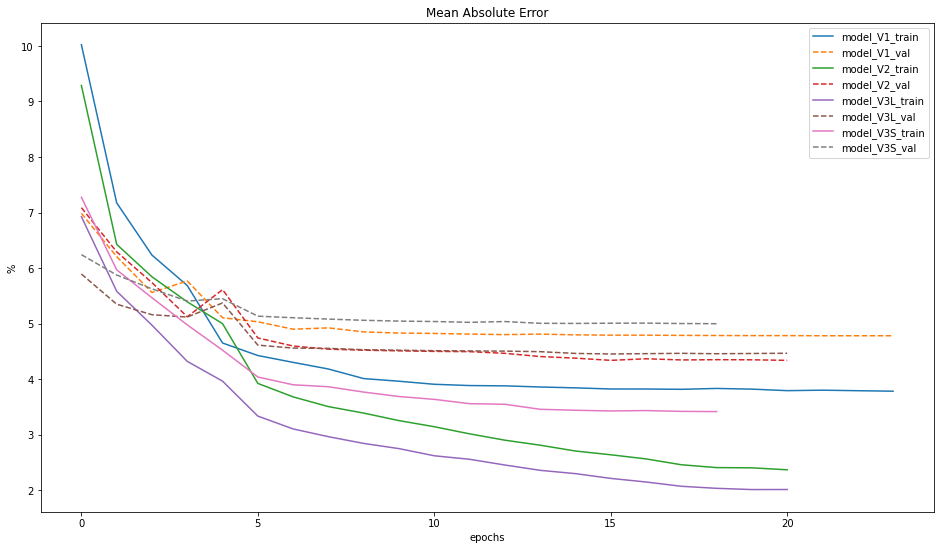

In [ ]:
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(16,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '--', label=cond+"_val")
plt.title("Mean Absolute Error")
plt.xlabel("epochs")
plt.ylabel("%")
plt.legend()
plt.show()
#Best of value is 0

## Evaluate performance on test set

In [ ]:
loss_V1, acc_V1 = model_V1.evaluate(test_ds)

45/45 [==============================] - 6s 122ms/step - loss: 4.6253 - mean_absolute_error: 4.6253


In [ ]:
loss_V2, acc_V2 = model_V2.evaluate(test_ds)

45/45 [==============================] - 2s 41ms/step - loss: 4.4813 - mean_absolute_error: 4.4813


In [ ]:
loss_V3L, acc_V3L = model_V3L.evaluate(test_ds)

45/45 [==============================] - 2s 38ms/step - loss: 4.8600 - mean_absolute_error: 4.8600


In [ ]:
loss_V3S, acc_V3S = model_V3S.evaluate(test_ds)

45/45 [==============================] - 1s 19ms/step - loss: 5.0165 - mean_absolute_error: 5.0165


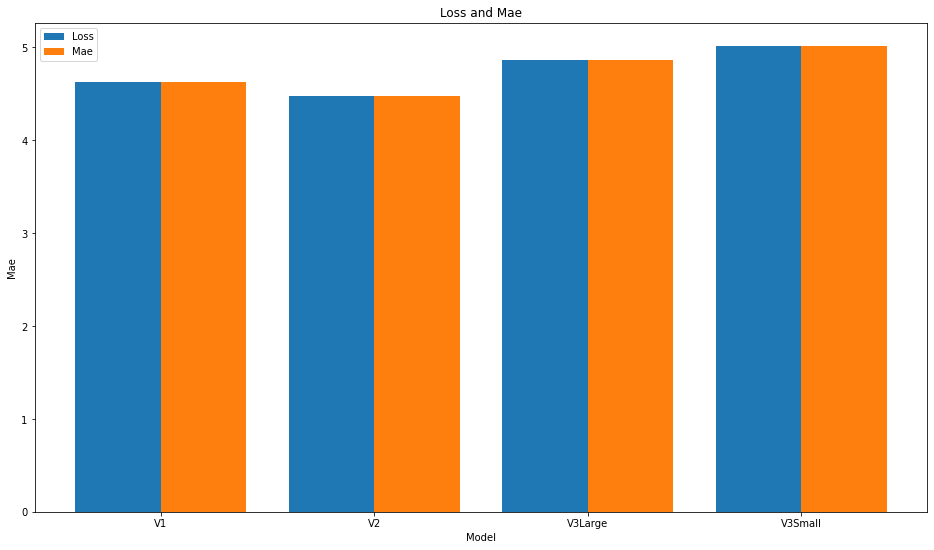

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

X = ['V1','V2','V3Large','V3Small']
Loss = np.array( [ loss_V1 , loss_V2 , loss_V3L , loss_V3S ] )
Mae = np.array( [ acc_V1 , acc_V2 , acc_V3L , acc_V3S ] )

X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  

plt.bar(X_axis - 0.2, Loss, 0.4, label = 'Loss')
plt.bar(X_axis + 0.2, Mae, 0.4, label = 'Mae')
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Mae")
plt.title("Loss and Mae")
plt.legend()
plt.show()
#Best of value is 0

## Size of Model

In [ ]:
import os
def getsize_model(file_path):
    size_byte = os.path.getsize(file_path)
    size_KB = size_byte / 1024
    size_MB = size_KB / 1024
    return size_MB

In [ ]:
size_V1 = getsize_model(model_path/'MobileNetV1.h5') 
size_V2 = getsize_model(model_path/'MobileNetV2.h5') 
size_V3L = getsize_model(model_path/'MobileNetV3L.h5') 
size_V3S = getsize_model(model_path/'MobileNetV3S.h5') 

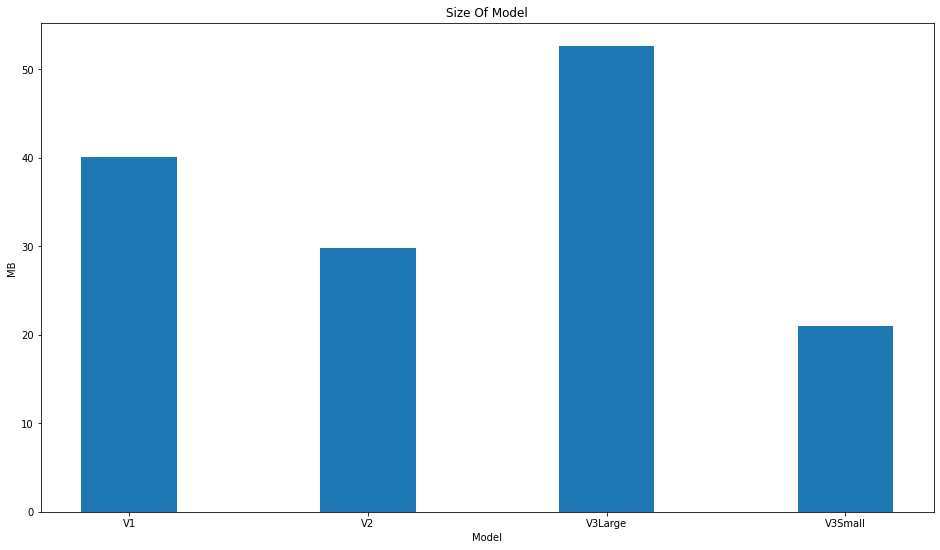

In [ ]:
X = ['V1','V2','V3Large','V3Small']
Y = np.array ( [ size_V1 , size_V2 , size_V3L , size_V3S ] )
X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  
plt.bar(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MB")
plt.title("Size Of Model")
plt.show()

# API

In [ ]:
! pip install flask_cors

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install DeepFace

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 2.3MB 17.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=fb2b5c232b8a987d187e06fcc0551fb04c0ab917e0008a08cfa7658eb9fea217
  Stored in directory: /root/.cache/pip/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


## Load Model

In [ ]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from deepface import DeepFace
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
model = load_model(model_path/'MobileNetV2.h5')

## Predict Age

In [ ]:
groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
def predict_class(age):
    if age <= 10: return groups_names[0] #Children 0 - 10
    if age <= 18: return groups_names[1] #Teenage 10 - 18
    if age <= 34: return groups_names[2] #Youth   19 - 34
    if age <= 60: return groups_names[3] #Middle  35 - 60
    return groups_names[4]               #Old     61+
def preprocess_image(data):
    image = Image.fromarray(data, 'RGB')
    image = image.resize((224,224))
    image = np.array(image)
    image = np.expand_dims(image, axis = 0)
    return image
def detect_face(img_path):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    detected_face = DeepFace.detectFace( img_path , detector_backend=backends[2])
    return detected_face
def predict_age(image):
    input = preprocess_image(image)
    age = model.predict(input)
    return int(age), predict_class(age)

## Test

Text(0.5, 1.0, 'Age: 37 - Middle')

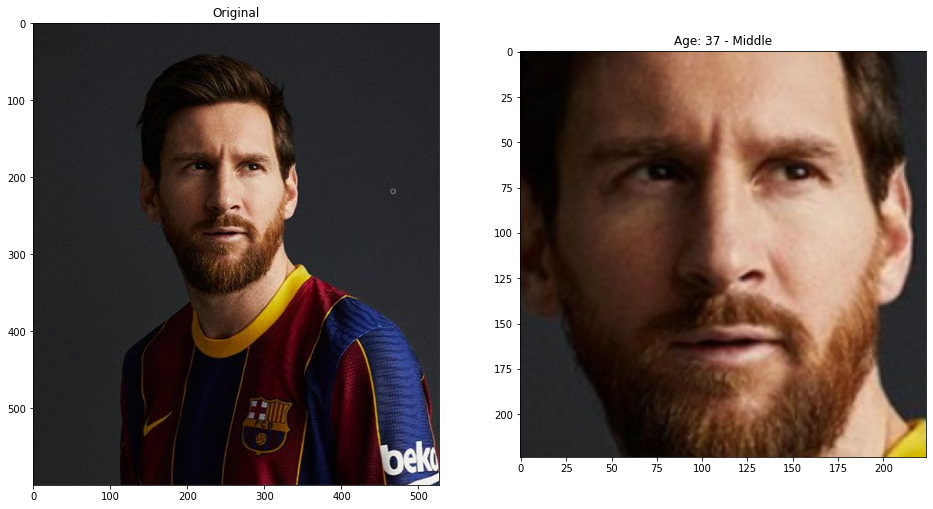

In [ ]:
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase2-18tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase1-19tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase4-21tuoi.png'
test = '/content/drive/MyDrive/FacialAge/Test_case/testcase7-33tuoi.jpg'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase8-33tuoi.jpg'
# test = '/content/drive/MyDrive/FacialAge/Test_case/test2.jpg'
detected_face = detect_face(test)
age, age_class = predict_age(detected_face)
text = 'Age: '+ str(age) + ' - '+ age_class

plt.figure(figsize=(16,9))
ax = plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(test))
plt.title('Original')
ax = plt.subplot(1, 2, 2)
plt.imshow(detected_face)
plt.title(text)